In [4]:
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score


def get_random_samples(base, n_samples, label):
    samples = base[base[:, -1] == label]
    
    if (n_samples):
        indexes = np.random.choice(samples.shape[0], n_samples, replace=False)
        return samples[indexes]
    
    return samples

0.9950000000000001


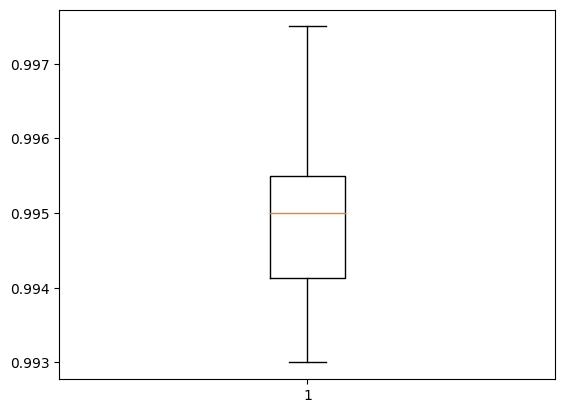

In [5]:
base = np.load(f"output/v2/bins_30.npy")

negatives = get_random_samples(base=base, n_samples=10000, label=-1)
positives = get_random_samples(base=base, n_samples=10000, label=1)

base_ready = np.vstack((positives, negatives))

y = base_ready[:, -1]
X = base_ready[:, 0:-1]

clf_svm = SVC()
kfold = StratifiedKFold(n_splits=10)
cv_results = cross_val_score(clf_svm, X, y, cv=kfold, scoring='accuracy')
print(cv_results.mean())
plt.boxplot(cv_results)
plt.show()